In [1]:
import sys

%cd ..
# add the src directory for the code
sys.path.append('src')

%cd .
sys.path.append('cdml-neurips2020/datasets')

/home/nikolas/Downloads/CS-673 (23-24)/Project/msft_causica
/home/nikolas/Downloads/CS-673 (23-24)/Project/msft_causica


In [2]:
import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch

from pytorch_lightning.callbacks import TQDMProgressBar
from tensordict import TensorDict

import pickle 
import cdt

from causica.datasets.causica_dataset_format import CAUSICA_DATASETS_PATH, Variable
from causica.distributions import ContinuousNoiseDist
from causica.lightning.data_modules.basic_data_module import BasicDECIDataModule
from causica.lightning.modules.deci_module import DECIModule
from causica.sem.sem_distribution import SEMDistributionModule
from causica.sem.structural_equation_model import ite
from causica.training.auglag import AugLagLRConfig

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script

print(np.__version__)

Detecting 1 CUDA device(s).


1.23.5


In [3]:
CAUSICA_DATASETS_PATH = '../cdml-neurips2020/'
#root_path = CAUSICA_DATASETS_PATH + 'datasets/'
root_path = CAUSICA_DATASETS_PATH + 'datasets/' + 'complexity_0/'

FILENAME = 'Complexity 0 Num Features 5 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1' + '-lagged.csv'

In [5]:
df = pd.read_csv(root_path + FILENAME)

# drop a handful of samples
#df = df[:5000]
display(df)
print("Data Shape:", df.shape)

,X1,X2,X3,X4,X5,Y1,X1:1,X2:1,X3:1,X4:1,X5:1,Y1:1
0,-0.275183,0.170985,-0.002987,0.324177,0.071403,-0.515259,-0.544704,0.144786,0.193016,0.006323,0.038558,0.123649
1,0.199111,-0.165159,0.465907,0.035926,-0.267722,-0.010486,-0.275183,0.170985,-0.002987,0.324177,0.071403,-0.515259
2,0.026381,0.319525,0.046672,-0.421083,-0.304405,0.071171,0.199111,-0.165159,0.465907,0.035926,-0.267722,-0.010486
3,0.103718,-0.017094,-0.008228,-0.394243,-0.175124,0.417724,0.026381,0.319525,0.046672,-0.421083,-0.304405,0.071171
4,-0.219821,-0.241414,-0.193457,0.351439,-0.190389,-0.177365,0.103718,-0.017094,-0.008228,-0.394243,-0.175124,0.417724
...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.269125,-0.135370,0.310658,-0.280420,-0.082736,0.072032,0.051833,-0.064905,-0.578255,-0.033802,0.069382,0.238714
995,-0.013667,-0.185535,-0.079222,0.276887,-0.184311,0.167233,0.269125,-0.135370,0.310658,-0.280420,-0.082736,0.072032
996,-0.058211,0.172136,0.216699,0.379458,-0.100734,-0.331179,-0.013667,-0.185535,-0.079222,0.276887,-0.184311,0.167233
997,0.100680,0.049301,0.691373,0.084668,-0.234956,0.026578,-0.058211,0.172136,0.216699,0.379458,-0.100734,-0.331179


Data Shape: (999, 12)


In [6]:
# load metadata telling us the data type of each column
# create the variables_spec json file from the dataframe 

variables_spec= []
for col in df.columns:
    variables_spec.append({"name": col, "type": "continuous", "group_name": col})

variables_path = root_path + FILENAME.replace('.csv', '.json')
with fsspec.open(variables_path, mode="w", encoding="utf-8") as f:
    json.dump({"variables": variables_spec}, f, indent=2)
        
with fsspec.open(variables_path, mode="r", encoding="utf-8") as f:
    variables_spec = json.load(f)["variables"]

print("Variables Spec:", variables_spec)

Variables Spec: [{'name': 'X1', 'type': 'continuous', 'group_name': 'X1'}, {'name': 'X2', 'type': 'continuous', 'group_name': 'X2'}, {'name': 'X3', 'type': 'continuous', 'group_name': 'X3'}, {'name': 'X4', 'type': 'continuous', 'group_name': 'X4'}, {'name': 'X5', 'type': 'continuous', 'group_name': 'X5'}, {'name': 'Y1', 'type': 'continuous', 'group_name': 'Y1'}, {'name': 'X1:1', 'type': 'continuous', 'group_name': 'X1:1'}, {'name': 'X2:1', 'type': 'continuous', 'group_name': 'X2:1'}, {'name': 'X3:1', 'type': 'continuous', 'group_name': 'X3:1'}, {'name': 'X4:1', 'type': 'continuous', 'group_name': 'X4:1'}, {'name': 'X5:1', 'type': 'continuous', 'group_name': 'X5:1'}, {'name': 'Y1:1', 'type': 'continuous', 'group_name': 'Y1:1'}]


Initialize a DECI model

In [7]:
data_module = BasicDECIDataModule(
    dataframe=df,
    variables=[Variable.from_dict(v) for v in variables_spec],
    batch_size=64,
    normalize=True 
)
num_nodes = len(data_module.dataset_train.keys())

display(data_module.dataset_train.keys()) # sanity check

_StringKeys({'X1': tensor([[-1.0855e+00],
        [ 5.1821e-01],
        [-6.5834e-02],
        [ 1.9566e-01],
        [-8.9830e-01],
        [ 1.2117e+00],
        [ 8.1709e-01],
        [-2.1544e-01],
        [ 1.1182e+00],
        [ 4.2765e-01],
        [-6.3390e-01],
        [ 2.4191e-01],
        [-1.1206e+00],
        [ 6.2369e-01],
        [-9.8709e-02],
        [ 8.7912e-02],
        [-1.8503e+00],
        [ 1.2031e+00],
        [ 1.8390e-02],
        [-6.9142e-02],
        [-3.7086e-01],
        [ 7.2881e-01],
        [ 2.5410e-01],
        [ 6.4355e-01],
        [ 9.6644e-01],
        [ 2.0410e+00],
        [-4.6241e-01],
        [-7.0366e-01],
        [-5.1507e-01],
        [ 6.3533e-01],
        [ 1.2539e+00],
        [ 3.5383e-01],
        [-8.9218e-01],
        [-5.0759e-01],
        [ 7.2827e-01],
        [ 5.7388e-01],
        [ 1.6987e-01],
        [-8.5305e-01],
        [-2.0013e-01],
        [ 7.5077e-02],
        [-1.7391e-01],
        [ 7.8408e-01],
        [ 4.905

In [8]:
print(f'Number of nodes: {num_nodes}') # sanity check

Number of nodes: 12


In [9]:
outcome = "Y1"

node_name_to_idx = {key: i for i, key in enumerate(data_module.dataset_train.keys())}
node_names = list(data_module.dataset_train.keys())

print(f'Node names: {node_names}')
num_nodes = len(node_names)

# extract the maximum lag available
max_lag = max([int(node.split(":")[1]) for node in node_names if ":" in node])
print(f'Max Lag: {max_lag}')

constraint_matrix = np.full((num_nodes, num_nodes), np.nan, dtype=np.float32)  # init constraint matrix with NaNs

lagged_nodes = [node for node in node_names if ":" in node]  # find all lagged nodes
print(f'Lagged nodes: {lagged_nodes}')

non_lagged_nodes = [node for node in node_names if node not in lagged_nodes]  # find all non-lagged nodes
print(f'Non-lagged nodes: {non_lagged_nodes}')

Node names: ['X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'X1:1', 'X2:1', 'X3:1', 'X4:1', 'X5:1', 'Y1:1']
Max Lag: 1
Lagged nodes: ['X1:1', 'X2:1', 'X3:1', 'X4:1', 'X5:1', 'Y1:1']
Non-lagged nodes: ['X1', 'X2', 'X3', 'X4', 'X5', 'Y1']


Proceed with adding time-series related constraints as prior knowledge (represented as a constraint matrix).

In [10]:
#no self loops
constraint_matrix[np.diag_indices(num_nodes)] = 0

for node in node_names:
    for node_2 in node_names:
        suffix = node.split(":")[1] if ":" in node else None
        suffix_2 = node_2.split(":")[1] if ":" in node_2 else None
        if suffix is not None and suffix_2 is not None and suffix == suffix_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
for node in node_names:
    prefix = node.split(":")[0]
    if ":" not in node:
        constraint_matrix[node_name_to_idx[node], :] = 0 # final timestep has no children
    #print("Node:", node, "Prefix:", prefix)
    for node_2 in node_names:
        prefix_2 = node_2.split(":")[0]
        if prefix == prefix_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
        if ":" in node_2 and prefix == node_2.split(":")[1]:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
            constraint_matrix[node_name_to_idx[node_2], node_name_to_idx[node]] = 0
        #no edges back to previous time steps
        if ":" in node and ":" in node_2 and int(node.split(":")[1]) < int(node_2.split(":")[1]):
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0
        if ":" not in node and ":" in node_2:
            constraint_matrix[node_name_to_idx[node], node_name_to_idx[node_2]] = 0            
        
# target node (outcome) has no children
constraint_matrix[node_name_to_idx[outcome], :] = 0
for i in range(1, max_lag + 1):
    constraint_matrix[node_name_to_idx[str(outcome) + ":" + str(i)], :] = 0

constraint_df = pd.DataFrame(constraint_matrix, index=node_names, columns=node_names)

print("Constraint Matrix:")
display(constraint_df)

Constraint Matrix:


,X1,X2,X3,X4,X5,Y1,X1:1,X2:1,X3:1,X4:1,X5:1,Y1:1
X1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1:1,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
X2:1,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
X3:1,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
X4:1,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


The number of edges to be learned during training is greatly reduced (the ones set to zero) due to the introduced constraints. 

E.g the DECI model now has to learn the existence and SEM parametrization of $X1:1 \rightarrow X_2$, $X3:1 \rightarrow Y_1$ etc.

In [11]:
pl.seed_everything(seed=42)  # set the random seed

lightning_module = DECIModule(
    noise_dist=ContinuousNoiseDist.SPLINE, # or ContinuousNoiseDist.GAUSSIAN for Gaussian noise
    embedding_size=64, # default
    out_dim_g=3, # default
    num_layers_g=3, # 2 is default
    num_layers_zeta=3, # 2 is default
    gumbel_temp=10, # default
    prior_sparsity_lambda=5.0,
    init_rho=1.0,
    init_alpha=0.020,
    auglag_config=AugLagLRConfig(
        max_inner_steps=1500,
        max_outer_steps=8,
        lr_init_dict={ # learning rates for each component
            "icgnn": 0.00076,
            "vardist": 0.0098,
            "functional_relationships": 3e-3,
            "noise_dist": 0.0070,
        },
    ),
)

lightning_module.constraint_matrix = torch.tensor(constraint_matrix)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=3000,
    fast_dev_run=test_run,
    callbacks=[TQDMProgressBar(refresh_rate=19)],
    enable_checkpointing=False
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Thankfully for us, the trainer of Pytorch lightning runs on all available GPUs (one in our case) by default.

In [12]:
display(type(lightning_module))
display(lightning_module)

causica.lightning.modules.deci_module.DECIModule

DECIModule(
  (auglag_loss): AugLagLossCalculator()
)

We may also use tensorboard to track values over epochs such as the training loss:

In [13]:
%load_ext tensorboard

In [14]:
trainer.fit(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | auglag_loss | AugLagLossCalculator  | 0     
1 | sem_module  | SEMDistributionModule | 29.3 K
------------------------------------------------------
29.1 K    Trainable params
144       Non-trainable params
29.3 K    Total params
0.117     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Updating alpha to: 0.09999999403953552
Updating alpha to: 0.4999999701976776
Updating alpha to: 2.499999761581421
Updating alpha to: 12.499999046325684
Updating alpha to: 62.499996185302734


We pickle the learned SEM model:

In [15]:
torch.save(lightning_module.sem_module, "deci_learned_SEM.pt")

#### Plot the inferred causal DAG 

In [16]:
sem_module: SEMDistributionModule = torch.load("deci_learned_SEM.pt")

# create a structural equation model using the most likely graph
sem = sem_module().mode

['X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'X1:1', 'X2:1', 'X3:1', 'X4:1', 'X5:1', 'Y1:1']


{'X1': 'X1',
 'X2': 'X2',
 'X3': 'X3',
 'X4': 'X4',
 'X5': 'X5',
 'Y1': 'Y1',
 'X1:1': 'X1:1',
 'X2:1': 'X2:1',
 'X3:1': 'X3:1',
 'X4:1': 'X4:1',
 'X5:1': 'X5:1',
 'Y1:1': 'Y1:1'}

'Number of edges: 17'

networkx.classes.digraph.DiGraph

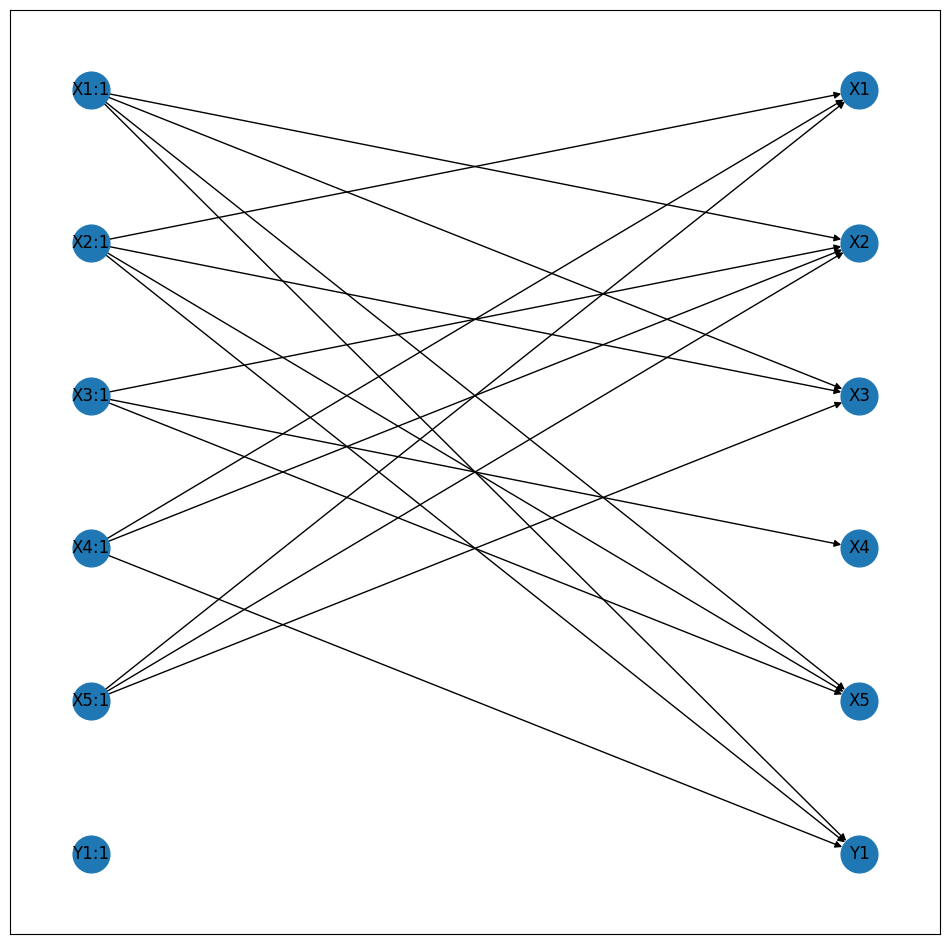

In [17]:
# Create the graph from sem.graph
graph_array = sem.graph.cpu().numpy()

graph = nx.from_numpy_array(graph_array, create_using=nx.DiGraph)
#graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))
graph = nx.relabel_nodes(graph, {i: key for i, key in enumerate(data_module.dataset_train.keys())})

# sanity check
#print(dict(data_module.dataset_train.keys()))
#print(list(data_module.dataset_train.keys()))

print(graph.nodes)

# Prepare the plot
#fig, axis = plt.subplots(1, 1, figsize=(20, 20))

# Set labels for nodes
#labels = {node: i for i, node in enumerate(graph.nodes)}
labels = {node: node for node in graph.nodes}
display(labels)

display(f'Number of edges: {len(graph.edges)}')

# Try to use graphviz layout, fallback to spring layout if not available
#try:
#    layout = nx.nx_agraph.graphviz_layout(graph, prog="dot")
#except (ModuleNotFoundError, ImportError):
#    layout = nx.layout.spring_layout(graph)

# Scatter plot nodes
#for node, i in labels.items():
#    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
#axis.legend()

# Draw the networkx graph
#nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

# Custom layout function to arrange nodes by time lag
def custom_layout(graph, max_lag):
    pos = {}
    var_names = sorted({node.split(':')[0] for node in graph.nodes})
    for i, var in enumerate(var_names):
        for lag in range(max_lag, 0, -1):
            node = f"{var}:{lag}"
            if node in graph.nodes:
                pos[node] = (max_lag - lag, -i)
        node = f"{var}"
        if node in graph.nodes:
            pos[node] = (max_lag + 1, -i)
    return pos

# Create custom layout
layout = custom_layout(graph, max_lag=max_lag)

fig, axis = plt.subplots(1, 1, figsize=(12, 12))
labels = {node: node for node in graph.nodes}

nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

display(type(graph))
plt.show()

#### Compare inferred graph with pickled ground truth

In [18]:
# Load the graph from the pickle file
GRAPH_FILENAME = root_path + FILENAME.split('-')[0] + '-causal_graph.pkl'
with open(GRAPH_FILENAME, 'rb') as f:
    gt_graph = pickle.load(f) 

type(gt_graph)

#graph = nx.relabel_nodes(graph, dict(enumerate(data_module.dataset_train.keys())))

# sanity checks
#display(gt_graph.nodes)
#display(gt_graph.edges)

#remove nodes starting with S
for node in list(gt_graph.nodes):
    if  node.startswith('S'):
        gt_graph.remove_node(node)
#display(gt_graph.nodes)

#same for edges
for edge in list(gt_graph.edges):
    if edge[0].startswith('S') or edge[1].startswith('S'):
        gt_graph.remove_edge(edge[0], edge[1])
display(gt_graph.edges)

#rename nodes from X_t-1 to X:1 etc
for node in list(gt_graph.nodes):
    dict = { node: node.replace('_t', '').replace('_', '_').replace(':1', ':1').replace('-', ':')}
    gt_graph = nx.relabel_nodes(gt_graph, dict)

display(gt_graph.nodes)

OutEdgeView([('X1_t-1', 'Y1_t'), ('X1_t-1', 'X2_t'), ('X2_t-1', 'Y1_t'), ('X2_t-1', 'X1_t'), ('X3_t-1', 'X2_t'), ('X3_t-1', 'X4_t'), ('X4_t-1', 'Y1_t'), ('X4_t-1', 'X1_t'), ('X5_t-1', 'X1_t'), ('X5_t-1', 'X2_t')])

NodeView(('Y1', 'Y1:1', 'X1', 'X1:1', 'X2', 'X2:1', 'X3', 'X3:1', 'X4', 'X4:1', 'X5', 'X5:1'))

#### Plot the ground-truth graph 

NodeView(('Y1', 'Y1:1', 'X1', 'X1:1', 'X2', 'X2:1', 'X3', 'X3:1', 'X4', 'X4:1', 'X5', 'X5:1'))

OutEdgeView([('X1:1', 'Y1'), ('X1:1', 'X2'), ('X2:1', 'Y1'), ('X2:1', 'X1'), ('X3:1', 'X2'), ('X3:1', 'X4'), ('X4:1', 'Y1'), ('X4:1', 'X1'), ('X5:1', 'X1'), ('X5:1', 'X2')])

NodeView(('X1', 'X2', 'X3', 'X4', 'X5', 'Y1', 'X1:1', 'X2:1', 'X3:1', 'X4:1', 'X5:1', 'Y1:1'))

OutEdgeView([('X1:1', 'X2'), ('X1:1', 'X3'), ('X1:1', 'X5'), ('X1:1', 'Y1'), ('X2:1', 'X1'), ('X2:1', 'X3'), ('X2:1', 'X5'), ('X2:1', 'Y1'), ('X3:1', 'X2'), ('X3:1', 'X4'), ('X3:1', 'X5'), ('X4:1', 'X1'), ('X4:1', 'X2'), ('X4:1', 'Y1'), ('X5:1', 'X1'), ('X5:1', 'X2'), ('X5:1', 'X3')])

Number of edges: 10


networkx.classes.digraph.DiGraph

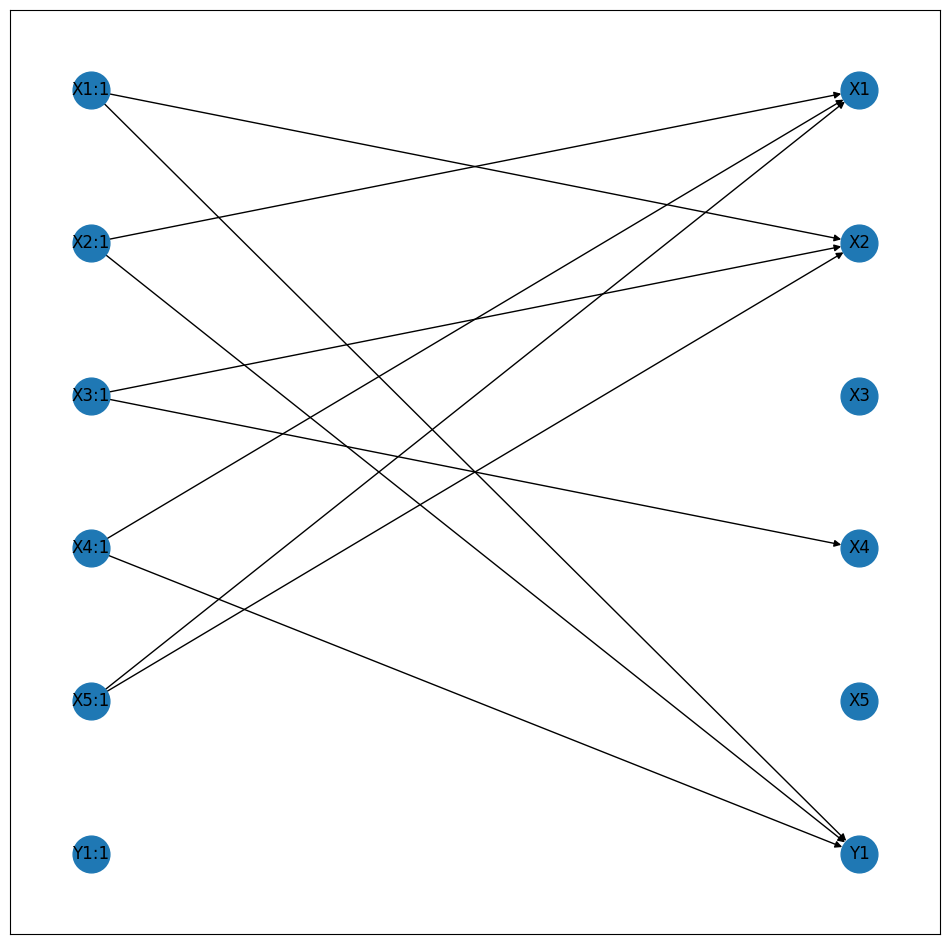

In [22]:
#fig, axis = plt.subplots(1, 1, figsize=(12, 12))

labels = {node: node for node in gt_graph.nodes}
#display(labels)

#rename nodes from X_t-1 to X:1 etc
for node in list(gt_graph.nodes):
    dict = { node: node.replace('_t', '').replace('_', '_').replace(':1', ':1').replace('-', ':')}
    gt_graph = nx.relabel_nodes(gt_graph, dict)

# sanity checks
display(gt_graph.nodes)
display(gt_graph.edges)

display(graph.nodes)
display(graph.edges)

print("Number of edges:", len(gt_graph.edges))

#try:
#    layout = nx.nx_agraph.graphviz_layout(graph, prog="dot")
#except (ModuleNotFoundError, ImportError):
#    layout = nx.layout.spring_layout(gt_graph)

#for node, i in labels.items():
#    axis.scatter(layout[node][0], layout[node][1], label=f"{i}: {node}")
#axis.legend()

#nx.draw_networkx(gt_graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

# custom layout function to arrange nodes by time lag
def custom_layout(graph, max_lag):
    pos = {}
    var_names = sorted({node.split(':')[0] for node in graph.nodes})
    for i, var in enumerate(var_names):
        for lag in range(max_lag, 0, -1):
            node = f"{var}:{lag}"
            if node in graph.nodes:
                pos[node] = (max_lag - lag, -i)
        node = f"{var}"
        if node in graph.nodes:
            pos[node] = (max_lag + 1, -i)
    return pos

# Create custom layout
layout = custom_layout(gt_graph, max_lag=max_lag)

fig, axis = plt.subplots(1, 1, figsize=(12, 12))
labels = {node: node for node in gt_graph.nodes}

nx.draw_networkx(gt_graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)

display(type(gt_graph))
#plt.show()

#### Compute performance metrics

In [23]:
import cdt #causal discovery toolbox

display(f'SHD: {cdt.metrics.SHD(gt_graph, graph, double_for_anticausal=True)}')

aupr, curve = cdt.metrics.precision_recall(gt_graph, graph, low_confidence_undirected=True)

display(f'Precision-Recall AUC: {aupr}, Curve: {curve}')

sid = cdt.metrics.SID(graph, gt_graph) #depends on the R-package SID - comment if not installed
display(f'SID: {sid}')

'SHD: 7'

'Precision-Recall AUC: 0.7941176470588236, Curve: [(0.5882352941176471, 1.0), (1.0, 0.0)]'

'SID: 18.0'

Max Lag: 1

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable X1 has 4 link(s):
        (X4 -1): max_pval = 0.00000, |min_val| =  0.241
        (X5 -1): max_pval = 0.00000, |min_val| =  0.151
        (X2 -1): max_pval = 0.00003, |min_val| =  0.133
        (X1 -1): max_pval = 0.02337, |min_val| =  0.072

    Variable X2 has 3 link(s):
        (X3 -1): max_pval = 0.00000, |min_val| =  0.387
        (X5 -1): max_pval = 0.00000, |min_val| =  0.317
        (X1 -1): max_pval = 0.00000, |min_val| =  0.297

    Variable X3 has 0 link(s):

    Variable X4 has 3 link(s):
        (X3 -1): max_pval = 0.00000, |min_val| =  0.478
        (X4 -1): max_pval = 0.03560, |min_val| =  0.067
        (Y1 -1): max_pval = 0.03921, |min_val| =  0.065

    Variable X5 has 0 link(s):

    Variable Y1 has 3 link(s):
    

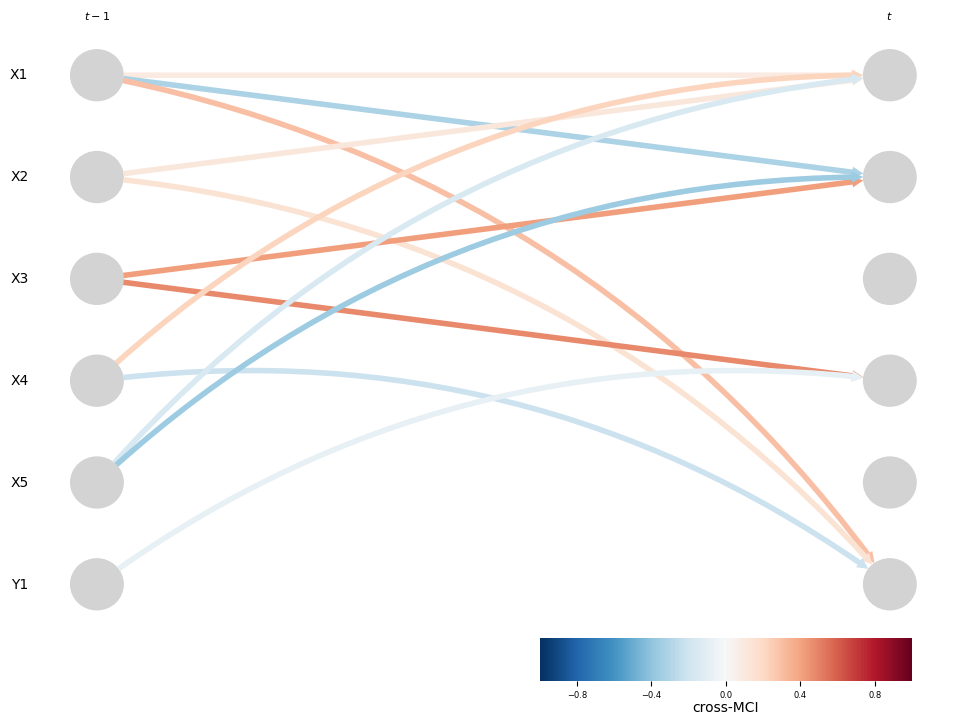

P-matrix values:
 [[[1.00000000e+00 4.68604320e-03]
  [1.00000000e+00 5.67099839e-25]
  [1.00000000e+00 6.53068514e-01]
  [1.00000000e+00 9.59505756e-01]
  [1.00000000e+00 4.20326058e-01]
  [1.00000000e+00 7.11214219e-22]]

 [[1.00000000e+00 4.96435531e-04]
  [1.00000000e+00 6.24916260e-01]
  [1.00000000e+00 9.19990804e-01]
  [1.00000000e+00 4.43708594e-01]
  [1.00000000e+00 6.70028084e-01]
  [1.00000000e+00 3.64812538e-06]]

 [[1.00000000e+00 7.94540768e-01]
  [1.00000000e+00 9.40166294e-44]
  [1.00000000e+00 3.61156067e-01]
  [1.00000000e+00 9.62401965e-59]
  [1.00000000e+00 4.41078162e-01]
  [1.00000000e+00 5.37816582e-01]]

 [[1.00000000e+00 8.11633293e-13]
  [1.00000000e+00 8.83224736e-01]
  [1.00000000e+00 7.40812077e-01]
  [1.00000000e+00 2.01525613e-01]
  [1.00000000e+00 5.35911132e-01]
  [1.00000000e+00 3.85252028e-12]]

 [[1.00000000e+00 4.69030227e-07]
  [1.00000000e+00 4.70250088e-32]
  [1.00000000e+00 1.97464158e-01]
  [1.00000000e+00 5.61794388e-01]
  [1.00000000e+00 7.29

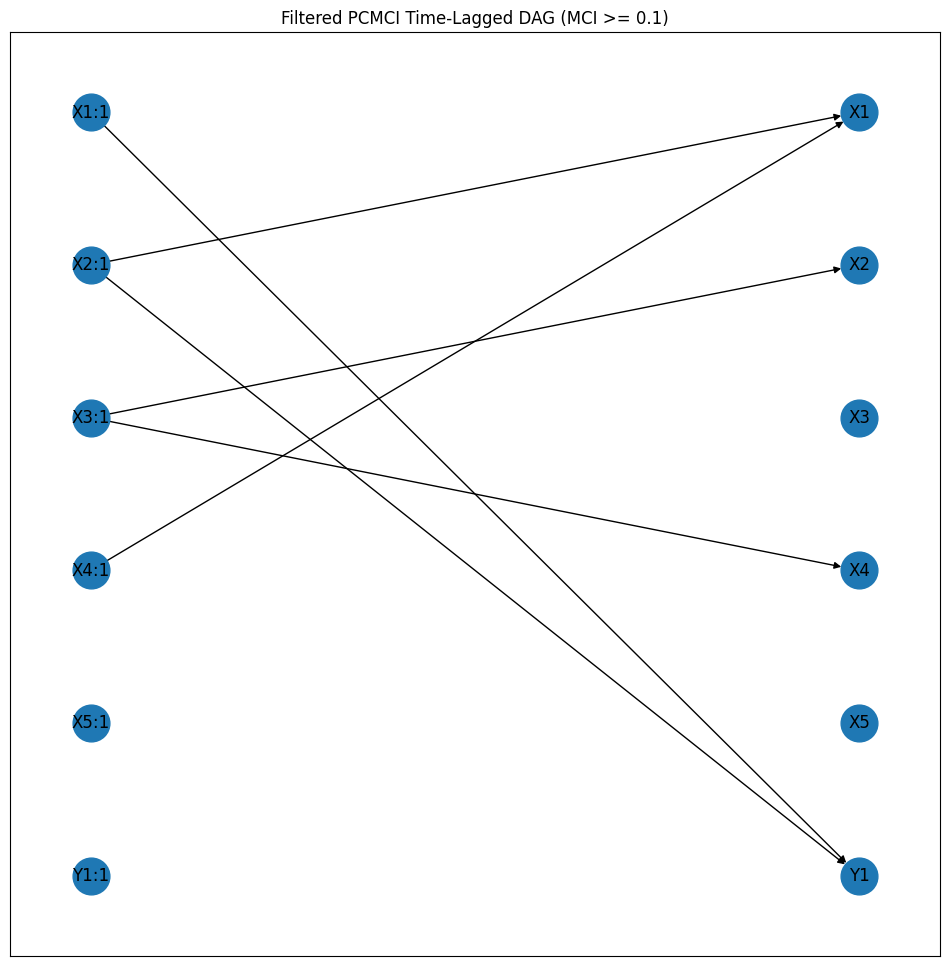

Nodes: ['X2', 'X1:1', 'X3', 'X4', 'X5', 'Y1', 'X2:1', 'X1', 'X3:1', 'X4:1', 'X5:1', 'Y1:1']
Edges: [('X1:1', 'Y1'), ('X2:1', 'X1'), ('X2:1', 'Y1'), ('X3:1', 'X2'), ('X3:1', 'X4'), ('X4:1', 'X1')]
SHD: 4
SID: 0.0


In [28]:
import numpy as np
import pandas as pd
import tigramite
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import networkx as nx
import matplotlib.pyplot as plt
import tigramite.plotting as tp

df = pd.read_csv(root_path + 'Complexity 0 Num Features 5 Num Latent 0 Max Lag 1 Min Lag 1 Target Max Parents 3 Max Children 0 Samples 1000 Noise 0.01 0.1' + '.csv')
data = df
tigramite_df = DataFrame(data.values, var_names=data.columns)

# extract max_lag from the string 
max_lag = int(FILENAME.split('Max Lag ')[1].split(' Min Lag')[0])
min_lag = int(FILENAME.split('Min Lag ')[1].split(' Target Max Parents')[0])
print(f'Max Lag: {max_lag}')

# Run PCMCI
def run_pcmci(tigramite_df, max_lag, min_lag):
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(dataframe=tigramite_df, cond_ind_test=parcorr, verbosity=1)
    results = pcmci.run_pcmci(tau_min=min_lag, tau_max=max_lag, pc_alpha=0.05, link_assumptions=None)
    p_matrix = results['p_matrix']
    q_matrix = pcmci.get_corrected_pvalues(p_matrix=p_matrix, tau_max=max_lag, fdr_method='fdr_bh')

    var_names = tigramite_df.var_names

    # Plot time series graph
    tp.plot_time_series_graph(
        figsize=(12, 8),
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI'
    )
    plt.show()

    return results, p_matrix

results, p_matrix = run_pcmci(tigramite_df, max_lag, min_lag)

# Check values in the p_matrix and link_matrix
link_matrix = results['val_matrix']
print("P-matrix values:\n", p_matrix)
print("Link-matrix values:\n", link_matrix)

# Create a filtered PCMCI graph based on significant links
def create_filtered_pcmci_graph(var_names, link_matrix, p_matrix, alpha_level=0.05, threshold=0.2):
    pcmci_graph = nx.DiGraph()
    max_lag = p_matrix.shape[2] - 1  # tau_max is equal to max_lag
    
    for i in range(link_matrix.shape[0]):
        for j in range(link_matrix.shape[1]):
            if i != j:
                for lag in range(1, max_lag + 1):
                    if p_matrix[i, j, lag] < alpha_level and link_matrix[i, j, lag] >= threshold:
                        source_node = f"{var_names[i]}:{lag}"
                        target_node = f"{var_names[j]}"
                        pcmci_graph.add_edge(source_node, target_node, label=f"lag {lag}")
                    pcmci_graph.add_node(f"{var_names[j]}")
                    pcmci_graph.add_node(f"{var_names[i]}:{lag}")

    return pcmci_graph

# Adjusted criteria for initial checks
pcmci_graph = create_filtered_pcmci_graph(tigramite_df.var_names, link_matrix, p_matrix, alpha_level=0.05, threshold=0.1)

# Custom layout function to arrange nodes by time lag
def custom_layout(graph, max_lag):
    pos = {}
    var_names = sorted({node.split(':')[0] for node in graph.nodes})
    for i, var in enumerate(var_names):
        for lag in range(max_lag, 0, -1):
            node = f"{var}:{lag}"
            if node in graph.nodes:
                pos[node] = (max_lag - lag, -i)
        node = f"{var}"
        if node in graph.nodes:
            pos[node] = (max_lag + 1, -i)
    return pos

# Create custom layout
layout = custom_layout(pcmci_graph, max_lag=3)

# Plot the filtered PCMCI graph with custom layout
fig, axis = plt.subplots(1, 1, figsize=(12, 12))
labels = {node: node for node in pcmci_graph.nodes}

nx.draw_networkx(pcmci_graph, pos=layout, with_labels=True, arrows=True, labels=labels, ax=axis, node_size=700)
plt.title('Filtered PCMCI Time-Lagged DAG (MCI >= 0.1)')
plt.show()

# Sanity checks
print("Nodes:", pcmci_graph.nodes)
print("Edges:", pcmci_graph.edges)

# Compare the PCMCI graph with the ground truth graph
shd = cdt.metrics.SHD(gt_graph, pcmci_graph, double_for_anticausal=True)
#aupr, curve = cdt.metrics.precision_recall(gt_graph, pcmci_graph, low_confidence_undirected=True)
sid = cdt.metrics.SID(pcmci_graph, gt_graph)

print(f'SHD: {shd}')
#print(f'Precision-Recall AUC: {aupr}, Curve: {curve}')
print(f'SID: {sid}')